In [1]:
import os
import pickle
import math
import random
import csv
from PIL import Image

import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten

print('All modules imported.')

All modules imported.


# 1 Reload the preprocessed data

In [2]:
# 1 Reload the preprocessed data

pickle_file = './pre-traffic-signs-data/pre-data.pickle'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    X_train = pickle_data['train_features']
    y_train = pickle_data['train_labels']
    X_valid = pickle_data['valid_features']
    y_valid = pickle_data['valid_labels']
    X_test = pickle_data['test_features']
    y_test = pickle_data['test_labels']
    signnames = pickle_data['signnames']
    del pickle_data  # Free up memory
    
# Shuffle the data set
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
X_test, y_test = shuffle(X_test, y_test)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)
print(len(signnames))
print('Data loaded.')

(34799, 32, 32, 3) (34799,)
(4410, 32, 32, 3) (4410,)
(12630, 32, 32, 3) (12630,)
43
Data loaded.


# 2 LeNet Architecture

In [3]:
def LeNet(x, KEEP_PROB):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Input = 32x32x3. Output = 28x28x6.
    # Convolutional. 
    conv1_w = tf.Variable(tf.truncated_normal((5, 5, 3, 6), mu, sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_w, [1, 1, 1, 1], 'VALID') + conv1_b
    # Activation.
    conv1 = tf.nn.relu(conv1)
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    pool1 = tf.nn.max_pool(conv1, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
       
    # Layer 2: Input = 14x14x6. Output = 10x10x16.
    # Convolutional. 
    conv2_w = tf.Variable(tf.truncated_normal((5, 5, 6, 16), mu, sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(pool1, conv2_w, [1, 1, 1, 1], 'VALID') + conv2_b
    # Activation.
    conv2 = tf.nn.relu(conv2)
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    pool2 = tf.nn.max_pool(conv2, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
      
    # Flatten. Input = 5x5x16. Output = 400.
    flat = flatten(pool2)   
    
    # Layer 3: Input = 400. Output = 120.
    # Fully Connected. 
    full1_w = tf.Variable(tf.truncated_normal((400, 120), mu, sigma))
    full1_b = tf.Variable(tf.zeros(120))
    full1 = tf.matmul(flat, full1_w) + full1_b
    # Activation.
    full1 = tf.nn.relu(full1) 
    # Dropout
    full1 = tf.nn.dropout(full1, KEEP_PROB)
    
    # Layer 4: Input = 120. Output = 84.
    # Fully Connected. 
    full2_w = tf.Variable(tf.truncated_normal((120, 84), mu, sigma))
    full2_b = tf.Variable(tf.zeros(84))
    full2 = tf.matmul(full1, full2_w) + full2_b
    # Activation.
    full2 = tf.nn.relu(full2)
    # Dropout
    full2 = tf.nn.dropout(full2, KEEP_PROB)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    full3_w = tf.Variable(tf.truncated_normal((84, 43), mu, sigma))
    full3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(full2, full3_w) + full3_b
    
    return logits

# 3 Training

## 3.1 Strategy

In [7]:
# Placeholder
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder_with_default(1.0, shape=())

# Hyperparameters
LEARNING_RATE = 1e-2
EPOCHS = 50
BATCH_SIZE = 128

# Train method
logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.GradientDescentOptimizer(learning_rate = LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)

## 3.2 Evaluation

In [8]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        accuracy, loss = sess.run([accuracy_operation, loss_operation], feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples, loss

## 3.3 Train the Model
A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting. The optimizer used is mini-batch gradient descent, each select a sub batch of all the training data.

Training...
EPOCH 1 : Validation Accuracy = 0.084
EPOCH 2 : Validation Accuracy = 0.172
EPOCH 3 : Validation Accuracy = 0.255
EPOCH 4 : Validation Accuracy = 0.315
EPOCH 5 : Validation Accuracy = 0.357
EPOCH 6 : Validation Accuracy = 0.392
EPOCH 7 : Validation Accuracy = 0.426
EPOCH 8 : Validation Accuracy = 0.452
EPOCH 9 : Validation Accuracy = 0.463
EPOCH 10 : Validation Accuracy = 0.487
EPOCH 11 : Validation Accuracy = 0.515
EPOCH 12 : Validation Accuracy = 0.542
EPOCH 13 : Validation Accuracy = 0.564
EPOCH 14 : Validation Accuracy = 0.590
EPOCH 15 : Validation Accuracy = 0.602
EPOCH 16 : Validation Accuracy = 0.644
EPOCH 17 : Validation Accuracy = 0.658
EPOCH 18 : Validation Accuracy = 0.675
EPOCH 19 : Validation Accuracy = 0.713
EPOCH 20 : Validation Accuracy = 0.720
EPOCH 21 : Validation Accuracy = 0.746
EPOCH 22 : Validation Accuracy = 0.740
EPOCH 23 : Validation Accuracy = 0.767
EPOCH 24 : Validation Accuracy = 0.771
EPOCH 25 : Validation Accuracy = 0.793
EPOCH 26 : Validation 

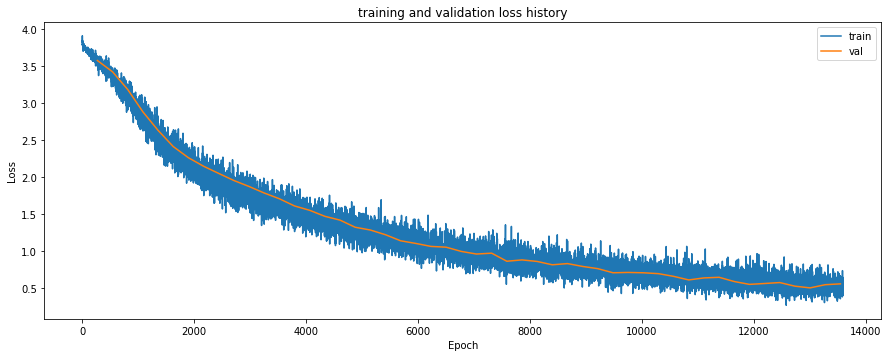

CPU times: user 2min 40s, sys: 21 s, total: 3min 1s
Wall time: 3min 21s


In [9]:
%%time
# 2min 7s
train_losses = []
valid_losses = []
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        print("EPOCH {} :".format(i+1), end=' ')
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            _, train_loss = sess.run([training_operation, loss_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            train_losses.append(train_loss)
        validation_accuracy, valid_loss = evaluate(X_valid, y_valid)
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        valid_losses.append(valid_loss)
                
    saver.save(sess, './model/lenet.ckpt')
    print("Model saved")
    
plt.subplot(2, 1, 2)
plt.plot(train_losses, label='train')
plt.plot([(i+1) * int(num_examples / BATCH_SIZE) for i in range(EPOCHS)], valid_losses, label='val')
plt.title('training and validation loss history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.gcf().set_size_inches(15, 12)
plt.legend()
plt.show()

# 4 Testing

## 4.1 Test the model on testing dataset

INFO:tensorflow:Restoring parameters from ./model/lenet.ckpt


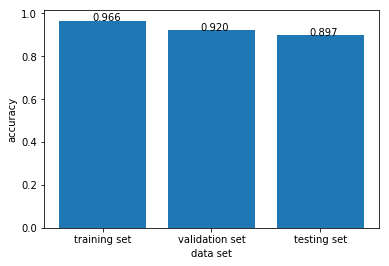

In [12]:
with tf.Session() as sess:
    saver.restore(sess, './model/lenet.ckpt')
    train_accuracy,_ = evaluate(X_train, y_train)
    valid_accuracy,_ = evaluate(X_valid, y_valid)
    test_accuracy,_ = evaluate(X_test, y_test)
    
accuracys = [train_accuracy, valid_accuracy, test_accuracy]
tick_labels = ["training set", "validation set", "testing set"]
plt.bar(range(3), accuracys)
plt.xlabel('data set')
plt.ylabel('accuracy')
plt.xticks(range(3), tick_labels)
for x_,y_ in zip(range(3), accuracys):
    plt.text(x_ - 0.1, y_, '%.3f'%y_)
plt.show()